In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Optional

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans

from myutils.stats import corrcoef, acfunc
from myutils.matplotlib import seaborn_theme

from src.pca import IPCA
from src.rzd import PlacePriceModel

seaborn_theme()

In [3]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'], encoding='utf-8')

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp,weekday,day_name,places_frac
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,86100.0,28500.0,5,Saturday,0.442857
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,86100.0,28500.0,6,Sunday,0.235714


In [4]:
trains = sorted(data['train'].unique().tolist())
len(trains)

112

## Модель

$$
\begin{cases}
    n(t, \tau) = \mu(\tau) + a(t) V(\tau) + \delta(t, \tau) \\
    C(t, \tau) = b_0 + b_1 n(t, \tau) + \varepsilon(t, \tau)
\end{cases}
$$

In [5]:
maxdays = 30
n_components = 10

In [6]:
metrics = pd.read_csv('../data/model_metrics.csv')

metrics.head(2)

,num,class,explained,r2,train
0,001А,Купе,0.812042,0.202094,001А-Купе
1,002А,Купе,0.832882,0.235136,002А-Купе


Значения метрик (доля объяснённой дисперсии для PCA и коэф-т детерминации для лин. регрессии) по разным поездам.

In [7]:
def truncate_values(df: pd.DataFrame, th: float, fill_value: float = np.nan) -> pd.DataFrame:
    df = df.copy()
    df.values[np.abs(df.values) < th] = fill_value
    
    return df

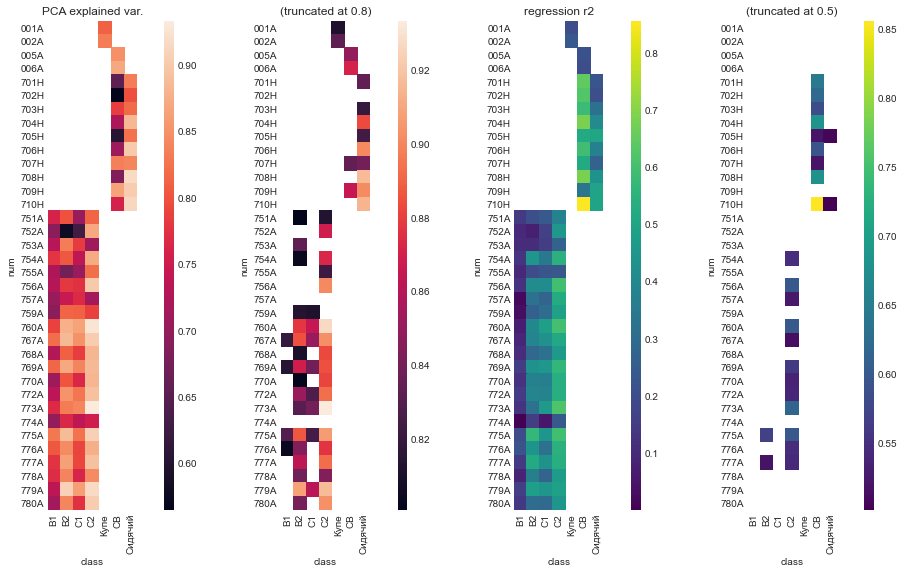

In [8]:
fig, axes = plt.subplots(ncols=4)
fig.set_size_inches(15, 9)
fig.subplots_adjust(wspace=0.7)
ax1, ax2, ax3, ax4 = axes.flatten()

explained = metrics.pivot(index='num', columns='class', values='explained')
r2 = metrics.pivot(index='num', columns='class', values='r2')

sns.heatmap(explained, ax=ax1, cbar_kws={'aspect': 50, 'pad': 0.2})
ax1.set_title('PCA explained var.')

explained = truncate_values(explained, th=0.8)

sns.heatmap(explained, ax=ax2, cbar_kws={'aspect': 50, 'pad': 0.2})
ax2.set_title('(truncated at 0.8)')

sns.heatmap(r2, ax=ax3, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax3.set_title('regression r2')

r2 = truncate_values(r2, th=0.5)

sns.heatmap(r2, ax=ax4, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax4.set_title('(truncated at 0.5)')

plt.savefig('../data/figures/model_metrics.pdf', transparent=True, bbox_inches='tight')
# plt.close()

<AxesSubplot:xlabel='class', ylabel='explained'>

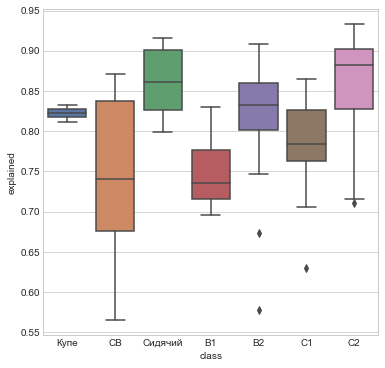

In [9]:
plt.figure(figsize=(6, 6))

sns.boxplot(data=metrics, x='class', y='explained')

In [10]:
explained_variance_ratio = pd.read_csv('../data/explained_variance_ratios.csv').set_index('train')
a = pd.read_csv('../data/principal_components.csv').set_index('date')
v = pd.read_csv('../data/eigenvectors.csv').set_index('train')
mean = pd.read_csv('../data/means.csv').set_index('train')

for df in [explained_variance_ratio, v, mean]:
    df.columns = df.columns.astype(int)

### Поезда с низкой EVR

In [11]:
mask = metrics['explained'] <= 0.7

metrics[mask]

,num,class,explained,r2,train
4,701Н,СВ,0.654776,0.645636,701Н-СВ
6,702Н,СВ,0.564850,0.622936,702Н-СВ
12,705Н,СВ,0.603237,0.519945,705Н-СВ
18,708Н,СВ,0.683204,0.682775,708Н-СВ
28,752А,B1,0.695569,0.095786,752А-B1
29,752А,B2,0.578164,0.075598,752А-B2
30,752А,C1,0.629884,0.164946,752А-C1
41,755А,B2,0.673630,0.195301,755А-B2
52,759А,B1,0.695626,0.028573,759А-B1


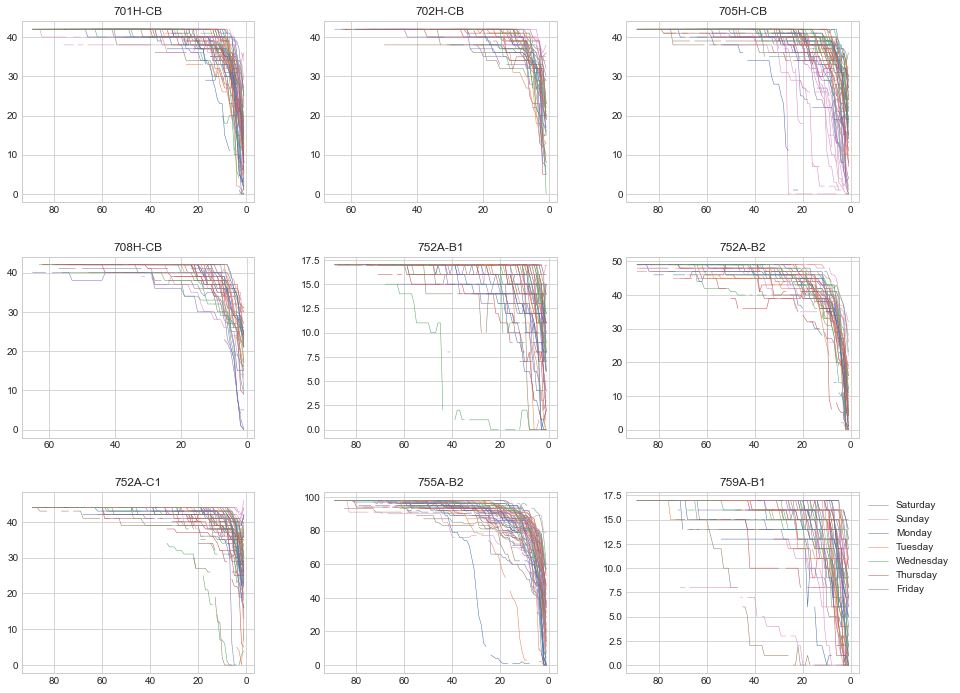

In [12]:
ncols = 3
nrows = mask.sum() // ncols + (mask.sum() % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(5 * ncols, 4 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

for train, ax in zip(metrics.loc[mask, 'train'], axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
for i in range(mask.sum(), len(axes)):
    axes[i].axis('off')

### Визуализация парной регрессии по поездам

## PCA

### $a(t)$

In [13]:
ncols = 6
nrows = a.shape[1] // ncols + (a.shape[1] % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(4 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.75)
axes = axes.flatten()

for train, ax in zip(a.columns, axes):
    a[train].plot(ax=ax, c='C2', lw=1, marker='.', markersize=2)
    
    ax.set_title(train)
    ax.set_xlabel(None)

for i in range(a.shape[1], len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/pcs.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [14]:
ncols = 6
nrows = a.shape[1] // ncols + (a.shape[1] % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(4 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(a.columns, axes):
    s = a[train].copy()
    s = s.dropna()
    
    acf = acfunc(s, method='spearman', maxlag=21)
    
    ax.plot(acf, lw=1)
    ax.fill_between(acf.index, acf.values, alpha=0.2)
    
    vmax = acf.abs().max() * 1.1
    ax.set_ylim(-vmax, vmax)
    
    ax.axhline(c='k', lw=0.5, ls='dashed', zorder=1)
    ax.set_title(train)

for i in range(a.shape[1], len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/pcs_acf.pdf', transparent=True, bbox_inches='tight')
plt.close()

## Кластеризация по $\mu(\tau)$

In [15]:
integral_mean = (mean - mean.shift(axis=1)).drop(columns=1)

integral_mean.head(2)

,2,3,4,5,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
train,,,,,,,,,,,,,,,,,,,,,
001А-Купе,0.045989,0.046679,0.037279,0.058939,0.031577,0.032326,0.028716,0.022863,0.017150,0.015185,...,0.014690,0.006671,0.007234,0.008751,0.010872,0.005712,0.005665,0.006025,0.002478,0.003737
002А-Купе,0.050417,0.049172,0.049153,0.042096,0.035556,0.024565,0.030537,0.016627,0.019556,0.012009,...,0.014739,0.010802,0.007570,0.010627,0.004960,0.007383,0.006505,0.004030,0.003584,0.004565


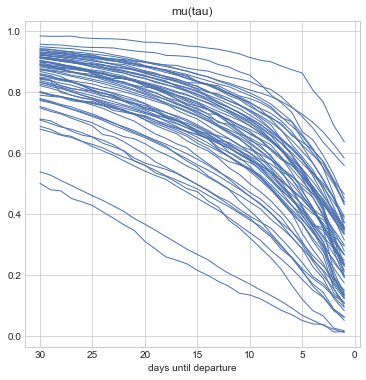

In [16]:
plt.figure(figsize=(6, 6))

for _, row in mean.iterrows():
    plt.plot(row, c='C0', lw=1)
    
plt.gca().invert_xaxis()

plt.title('mu(tau)')
plt.xlabel('days until departure')

plt.savefig('../data/figures/means.pdf', transparent=True, bbox_inches='tight')

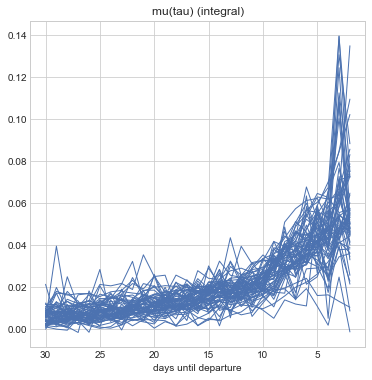

In [17]:
plt.figure(figsize=(6, 6))

for _, row in integral_mean.iterrows():
    plt.plot(row, c='C0', lw=1)
    
plt.gca().invert_xaxis()

plt.title('mu(tau) (integral)')
plt.xlabel('days until departure')

plt.savefig('../data/figures/integral_means.pdf', transparent=True, bbox_inches='tight')

Векторы $\mu(\tau)$ по разным кластерам.

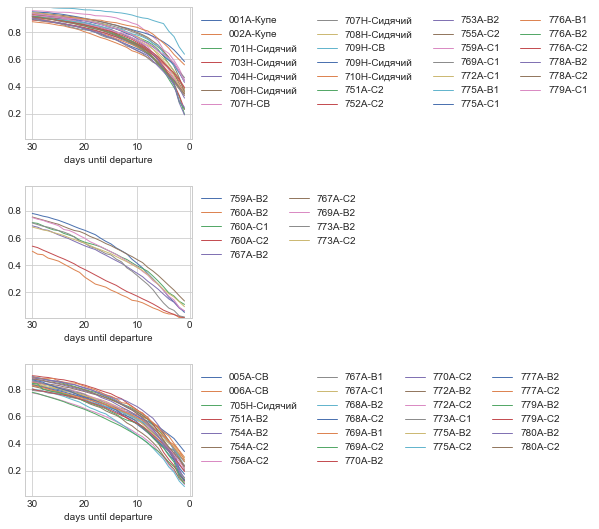

In [18]:
k = 3
kmeans = KMeans(n_clusters=k).fit(mean.values)
mu_clusters = kmeans.predict(mean.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

mu_min = mean.min().min()
mu_max = mean.max().max()

for cluster, ax in zip(np.unique(mu_clusters), axes):
    mean_i = mean.loc[mu_clusters == cluster]
    
    mean_i.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=mean_i.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(mu_min, mu_max)
    
    ax.invert_xaxis()

plt.savefig('../data/figures/mean_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

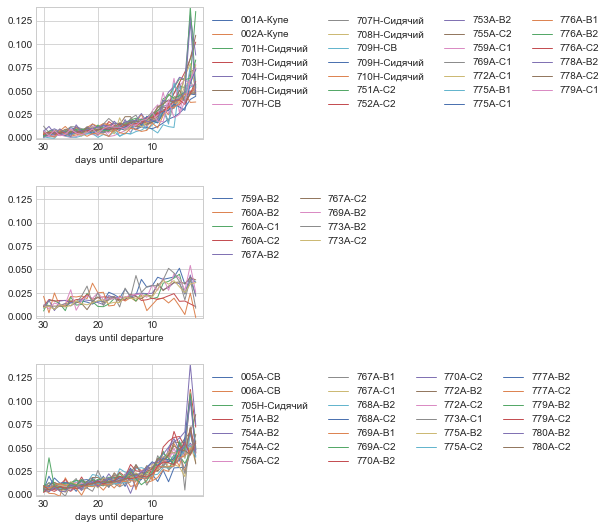

In [19]:
# k = 3
# kmeans = KMeans(n_clusters=k).fit(integral_mean.values)
# mu_clusters = kmeans.predict(integral_mean.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

int_mu_min = integral_mean.min().min()
int_mu_max = integral_mean.max().max()

for cluster, ax in zip(np.unique(mu_clusters), axes):
    mean_i = integral_mean.loc[mu_clusters == cluster]
    
    mean_i.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=mean_i.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(int_mu_min, int_mu_max)
    
    ax.invert_xaxis()

plt.savefig('../data/figures/integral_mean_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [20]:
train_class = mean.index.map(lambda x: x.split('-')[1])

pd.crosstab(mu_clusters, train_class)

col_0,B1,B2,C1,C2,Купе,СВ,Сидячий
row_0,,,,,,,
0,2,3,5,5,2,2,8
1,0,5,1,3,0,0,0
2,2,9,2,10,0,2,1


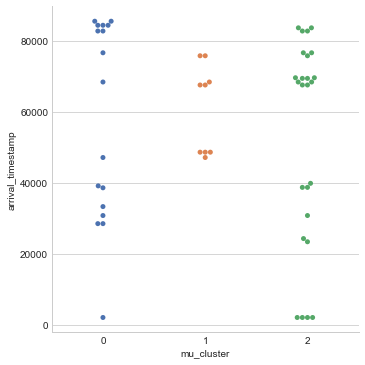

In [21]:
df = pd.Series(mu_clusters, index=mean.index, name='mu_cluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_timestamp']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.catplot(data=df, x='mu_cluster', y='arrival_timestamp', kind='swarm')

<AxesSubplot:xlabel='mu_cluster', ylabel='avg_price'>

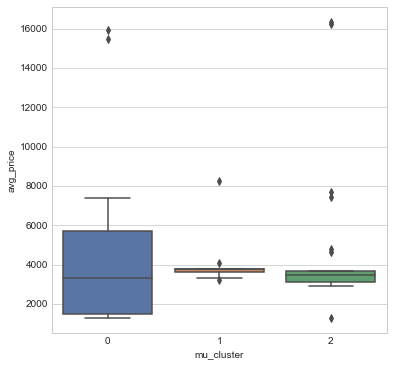

In [22]:
avg_price = data.groupby('train')['price'].mean().reindex(mean.index)

df = pd.DataFrame({'mu_cluster': mu_clusters, 'avg_price': avg_price})

plt.figure(figsize=(6, 6))
sns.boxplot(data=df, x='mu_cluster', y='avg_price')

## Кластеризация по $V(\tau)$

In [23]:
integral_v = (v - v.shift(axis=1)).drop(columns=1)

integral_v.head(2)

,2,3,4,5,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
train,,,,,,,,,,,,,,,,,,,,,
001А-Купе,0.031172,0.027018,0.015539,-0.006628,0.004092,0.001667,0.002468,-0.004828,-0.007028,-0.001352,...,-0.010041,-0.003035,-0.004149,-0.003705,-0.010466,-0.006874,0.001968,-0.005552,0.001001,-0.003340
002А-Купе,0.012227,-0.019315,0.010851,0.009454,-0.013923,0.011935,-0.008922,0.002100,0.004388,0.002632,...,-0.012686,-0.009510,-0.007883,-0.010053,-0.006831,-0.006388,-0.003688,-0.003144,-0.006937,-0.005655


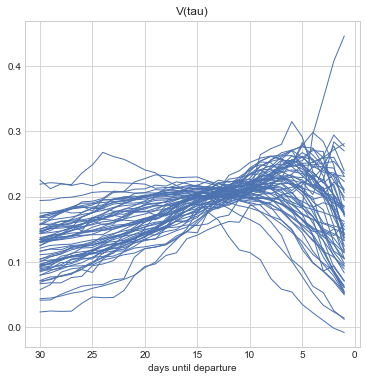

In [24]:
plt.figure(figsize=(6, 6))

for _, row in v.iterrows():
    plt.plot(row, c='C0', lw=1)
    
plt.gca().invert_xaxis()

plt.title('V(tau)')
plt.xlabel('days until departure')

plt.savefig('../data/figures/eigenvectors.pdf', transparent=True, bbox_inches='tight')

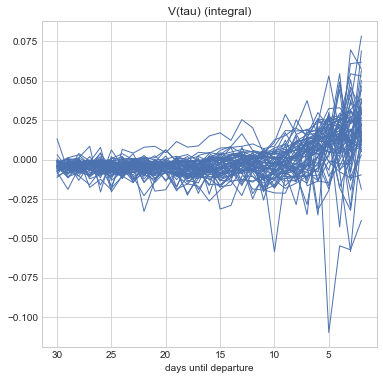

In [25]:
plt.figure(figsize=(6, 6))

for _, row in integral_v.iterrows():
    plt.plot(row, c='C0', lw=1)
    
plt.gca().invert_xaxis()

plt.title('V(tau) (integral)')
plt.xlabel('days until departure')

plt.savefig('../data/figures/integral_eigenvectors.pdf', transparent=True, bbox_inches='tight')

Векторы $V(\tau)$ по разным кластерам.

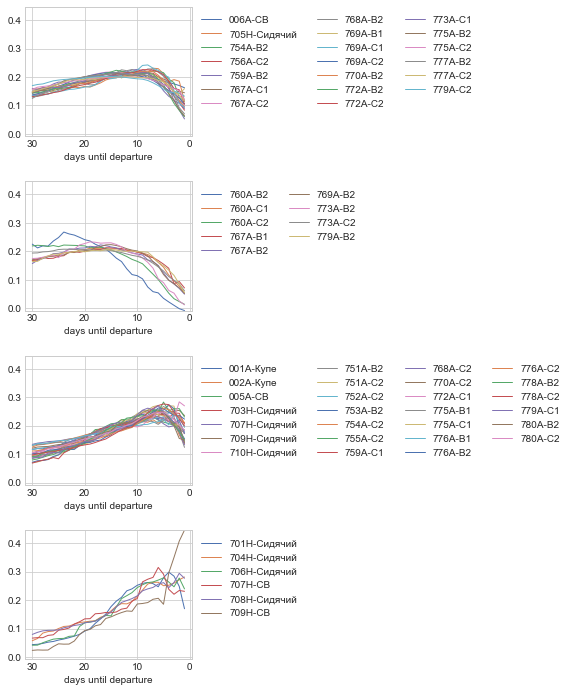

In [26]:
k = 4
kmeans = KMeans(n_clusters=k).fit(v.values)
eig_clusters = kmeans.predict(v.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

vmin = v.min().min()
vmax = v.max().max()

for cluster, ax in zip(np.unique(eig_clusters), axes):
    vi = v.loc[eig_clusters == cluster]
    
    vi.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=vi.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(vmin, vmax)
    
    ax.invert_xaxis()

for i in range(k, len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/eigenvector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

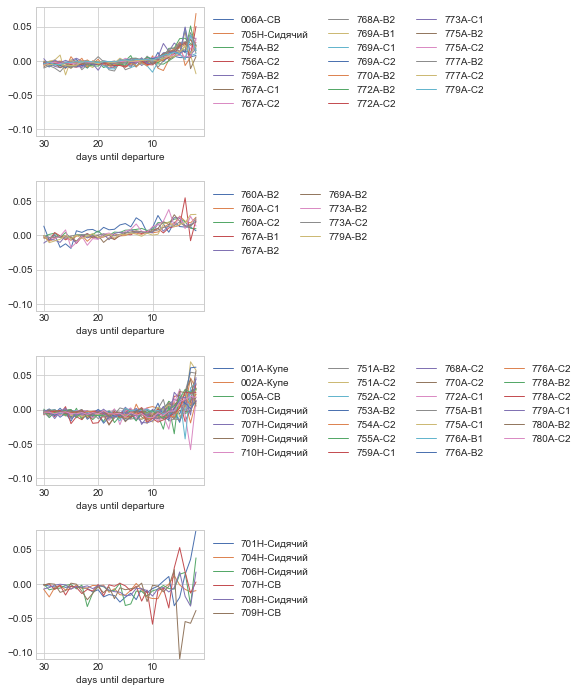

In [27]:
# k = 3
# kmeans = KMeans(n_clusters=k).fit(v.values)
# eig_clusters = kmeans.predict(v.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

int_vmin = integral_v.min().min()
int_vmax = integral_v.max().max()

for cluster, ax in zip(np.unique(eig_clusters), axes):
    vi = integral_v.loc[eig_clusters == cluster]
    
    vi.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=vi.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(int_vmin, int_vmax)
    
    ax.invert_xaxis()

for i in range(k, len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/integral_eigenvector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [28]:
pd.crosstab(eig_clusters, train_class)

col_0,B1,B2,C1,C2,Купе,СВ,Сидячий
row_0,,,,,,,
0,1,7,3,7,0,1,1
1,1,5,1,2,0,0,0
2,2,5,4,9,2,1,4
3,0,0,0,0,0,2,4


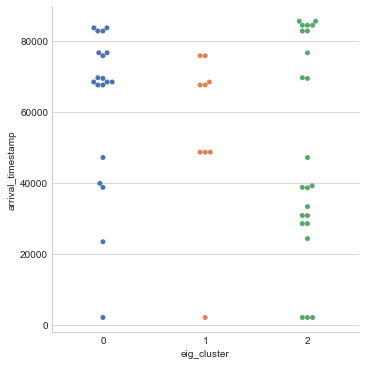

In [29]:
df = pd.Series(eig_clusters, index=v.index, name='eig_cluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_timestamp']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.catplot(data=df, x='eig_cluster', y='arrival_timestamp', kind='swarm')

<AxesSubplot:xlabel='eig_cluster', ylabel='avg_price'>

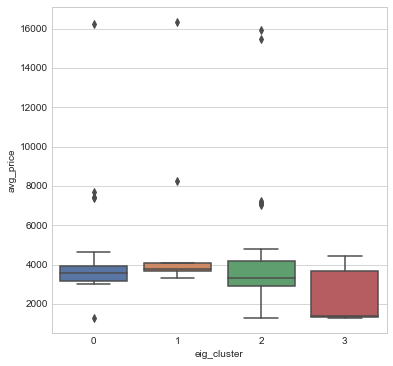

In [30]:
df = pd.DataFrame({'eig_cluster': eig_clusters, 'avg_price': avg_price})

plt.figure(figsize=(6, 6))
sns.boxplot(data=df, x='eig_cluster', y='avg_price')

### Би-кластеризация

In [31]:
clusters = pd.DataFrame({'mu': mu_clusters, 'eig': eig_clusters})

clusters['both'] = clusters['mu'].astype(str) + '-' + clusters['eig'].astype(str)

biclusters = clusters['both'].values

clusters.head(2)

,mu,eig,both
0,0,2,0-2
1,0,2,0-2


In [32]:
pd.crosstab(mu_clusters, eig_clusters)

col_0,0,1,2,3
row_0,,,,
0,1,0,20,6
1,2,7,0,0
2,17,2,7,0


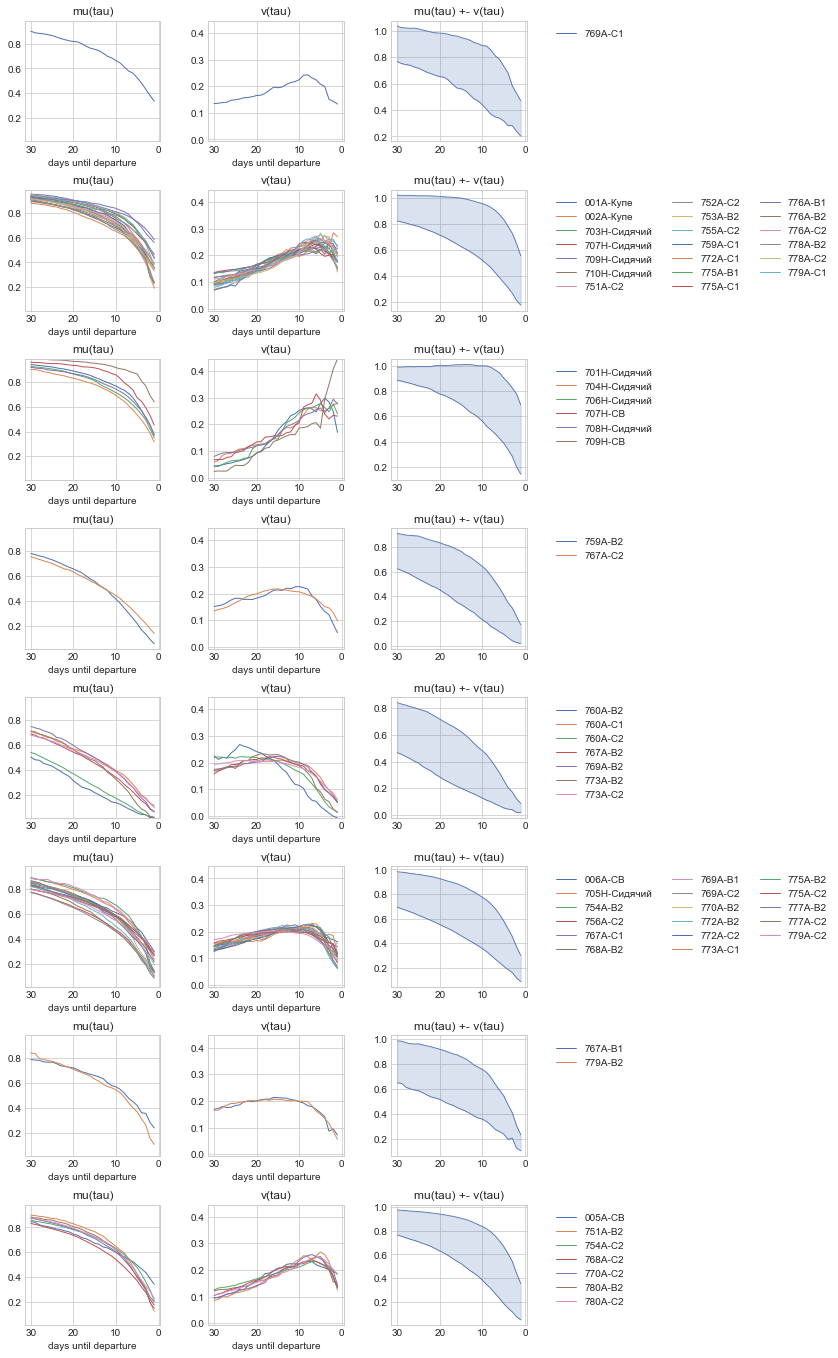

In [33]:
ncols = 3
nrows = np.unique(biclusters).size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.4, wspace=0.35)

for cluster, (ax1, ax2, ax3) in zip(np.unique(biclusters), axes):
    mean_i = mean.loc[biclusters == cluster]
    
    mean_i.T.plot(ax=ax1, lw=1, legend=False)
    ax1.set_title('mu(tau)')
    ax1.set_xlabel('days until departure')
    ax1.set_ylim(mu_min, mu_max)
    
    ax1.invert_xaxis()
    
    vi = v.loc[biclusters == cluster]
    
    vi.T.plot(ax=ax2, lw=1)
    ax2.legend(loc='upper left', bbox_to_anchor=(2.5, 1), ncol=vi.shape[0] // 8 + 1)
    ax2.set_title('v(tau)')
    ax2.set_xlabel('days until departure')
    ax2.set_ylim(vmin, vmax)
    
    ax2.invert_xaxis()
    
    mean_i = mean_i.mean(axis=0)
    vi = vi.mean(axis=0)
    
    lower = mean_i - vi
    upper = mean_i + vi
    
    ax3.plot(lower, c='C0', lw=0.8)
    ax3.plot(upper, c='C0', lw=0.8)
    ax3.fill_between(mean_i.index, lower, upper, color='C0', alpha=0.2)
    ax3.set_title('mu(tau) +- v(tau)')
    ax2.set_xlabel('days until departure')
    
    ax3.invert_xaxis()

plt.savefig('../data/figures/biclusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [34]:
pd.crosstab(biclusters, train_class)

col_0,B1,B2,C1,C2,Купе,СВ,Сидячий
row_0,,,,,,,
0-0,0,0,1,0,0,0,0
0-2,2,3,4,5,2,0,4
0-3,0,0,0,0,0,2,4
1-0,0,1,0,1,0,0,0
1-1,0,4,1,2,0,0,0
2-0,1,6,2,6,0,1,1
2-1,1,1,0,0,0,0,0
2-2,0,2,0,4,0,1,0


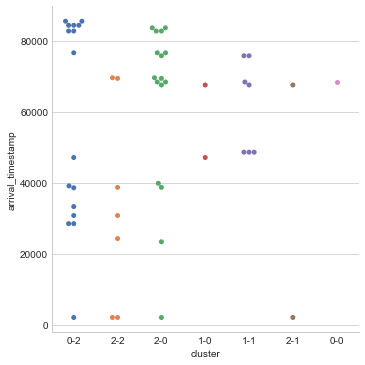

In [35]:
df = pd.Series(biclusters, index=mean.index, name='cluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_timestamp']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.catplot(data=df, x='cluster', y='arrival_timestamp', kind='swarm')

<AxesSubplot:xlabel='bicluster', ylabel='avg_price'>

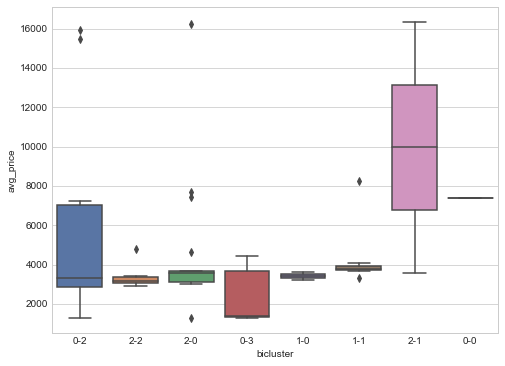

In [36]:
df = pd.DataFrame({'bicluster': biclusters, 'avg_price': avg_price})

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='bicluster', y='avg_price')

In [37]:
!jupyter nbconvert --to html 2_model.ipynb

[NbConvertApp] Converting notebook 2_model.ipynb to html
[NbConvertApp] Writing 2312032 bytes to 2_model.html


Расшифровка моделей для каждого кластера.